In [1]:
"""
Computes a julia set pixel.
"""
function juliaSetPixel(z0, c)
    z = z0
    niter = 255
    for i in 1:niter
        abs2(z)> 4.0 && return (i - 1)%UInt8
        z = z*z + c
    end
    return niter%UInt8
end

"""
Computes a column (`j`) of the julia set image.
The result is written into the corresponding column of `pic`.
"""
function calcColumn!(pic, c, n, j)
    x = -2.0 + (j-1)*4.0/(n-1)
    for i in 1:n
        y = -2.0 + (i-1)*4.0/(n-1)
        @inbounds pic[i,j] = juliaSetPixel(x+im*y, c)
    end
    nothing
end

"""
Sequential column-by-column construction of the julia set image
"""
function juliaSetCalc!(pic, c, n)
    for j in 1:n
        calcColumn!(pic, c, n, j)
    end
    nothing
end

"""
Compute the julia set image using the method `method`.
"""
function juliaSet(method = juliaSetCalc!, extra...)
    c = -0.79 + 0.15*im
    n = 1000
    pic = Array{UInt8,2}(undef,n,n)
    method(pic, c, n, extra...)
    return pic
end

juliaSet

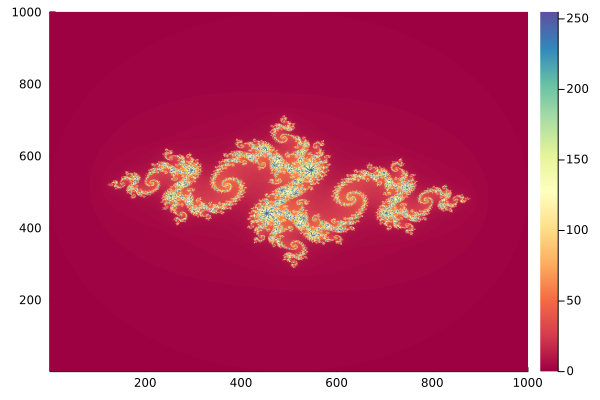

In [2]:
using Plots

frac = juliaSet()
plot(heatmap(1:size(frac,1),1:size(frac,2), frac, color=:Spectral))

In [3]:
using BenchmarkTools
@btime juliaSet();

  58.634 ms (2 allocations: 976.70 KiB)


## Multithreading: `@threads`

In [4]:
import Base.Threads: @threads

function juliaSetCalcThread!(pic, c, n)
    @threads for j in 1:n
        calcColumn!(pic, c, n, j)
    end
    return nothing
end

juliaSetCalcThread! (generic function with 1 method)

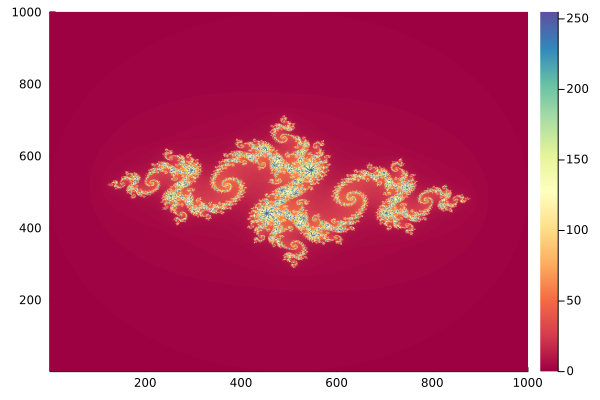

In [5]:
frac = juliaSet(juliaSetCalcThread!)
plot(heatmap(1:size(frac,1),1:size(frac,2), frac, color=:Spectral))

In [6]:
@btime juliaSet(juliaSetCalcThread!);

  17.922 ms (35 allocations: 979.17 KiB)


In [7]:
# Turon on debugging :D
import Base.Threads: nthreads, threadid

function calcColumn!(pic, c, n, j)
    x = -2.0 + (j-1)*4.0/(n-1)
    cols[j] = threadid()
    for i in 1:n
        y = -2.0 + (i-1)*4.0/(n-1)
        @inbounds pic[i,j] = juliaSetPixel(x+im*y, c)
    end
    nothing
end

function juliaSetPixel(z0, c)
    z = z0
    niter = 255
    for i in 1:niter
        niters[threadid()] += 1
        abs2(z)> 4.0 && return (i - 1)%UInt8
        z = z*z + c
    end
    return niter%UInt8
end

juliaSetPixel (generic function with 1 method)

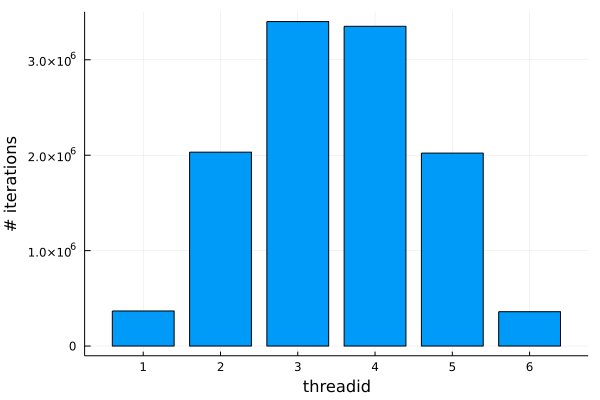

In [8]:
niters = zeros(nthreads())
cols = zeros(1000)
juliaSet(juliaSetCalcThread!)
bar(niters, xlab="threadid", ylab="# iterations", legend=false)

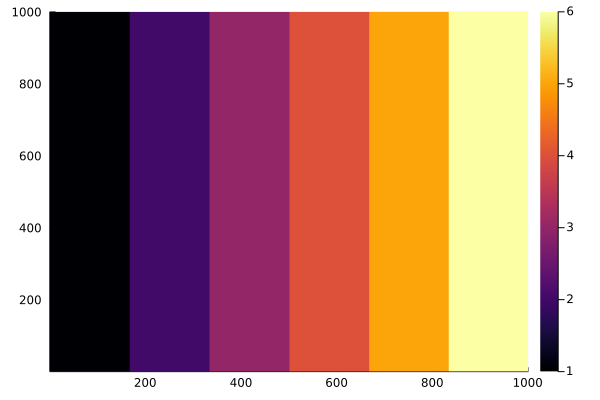

In [9]:
heatmap([c for i in 1:length(cols), c in cols])

## Multithreading: `@spawn`

In [10]:
import Base.Threads: @spawn

function juliaSetCalcSpawn!(pic, c, n)
    @sync for j in 1:n
        @spawn calcColumn!(pic, c, n, j)
    end
    return nothing
end

juliaSetCalcSpawn! (generic function with 1 method)

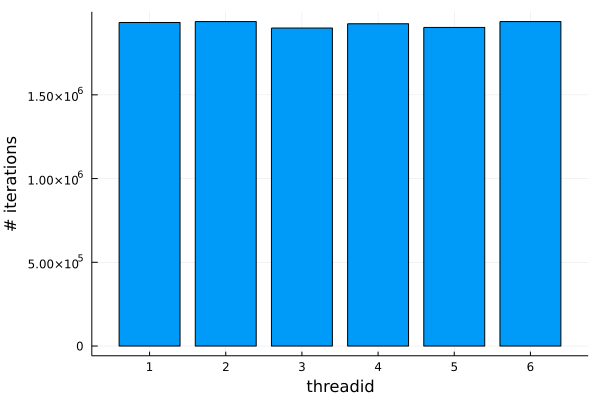

In [11]:
niters = zeros(nthreads())
cols = zeros(1000)
juliaSet(juliaSetCalcSpawn!)
bar(niters, xlab="threadid", ylab="# iterations", legend=false)

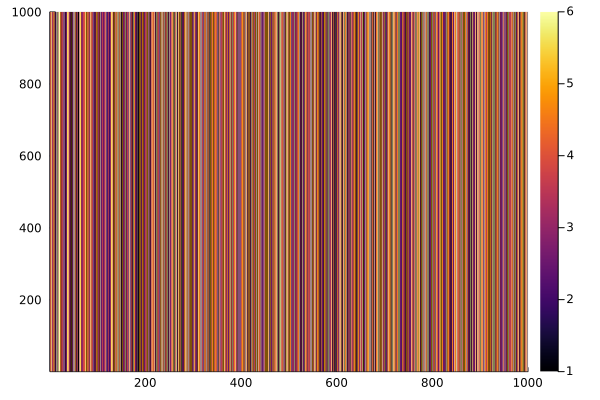

In [12]:
heatmap([c for i in 1:length(cols), c in cols])

In [13]:
# Turn off debugging :D
function calcColumn!(pic, c, n, j)
    x = -2.0 + (j-1)*4.0/(n-1)
    for i in 1:n
        y = -2.0 + (i-1)*4.0/(n-1)
        @inbounds pic[i,j] = juliaSetPixel(x+im*y, c)
    end
    nothing
end

function juliaSetPixel(z0, c)
    z = z0
    niter = 255
    for i in 1:niter
        abs2(z)> 4.0 && return (i - 1)%UInt8
        z = z*z + c
    end
    return niter%UInt8
end

juliaSetPixel (generic function with 1 method)

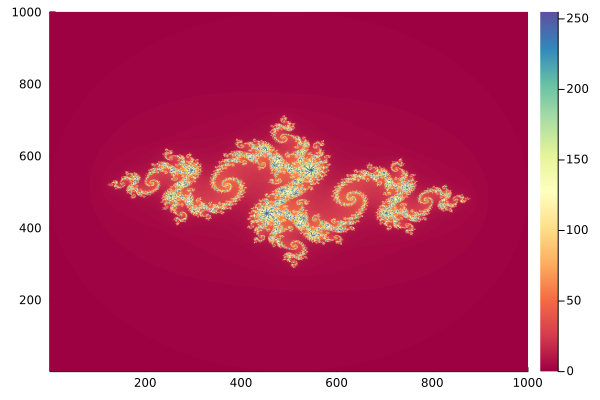

In [14]:
frac = juliaSet(juliaSetCalcSpawn!)
plot(heatmap(1:size(frac,1),1:size(frac,2), frac, color=:Spectral))

In [15]:
@btime juliaSet(juliaSetCalcSpawn!);

  10.674 ms (6022 allocations: 1.38 MiB)


Based on http://www.cs.unb.ca/~aubanel/JuliaMultithreadingNotes.html.